In [2]:
import numpy

In [12]:
import matplotlib.pyplot as plt

In [1]:
from scipy import optimize

In [3]:
class DAK():
	"""
	Dranchuk-Abu-Kassem method represents the Standing-Katz correlation:
	0.2 < Pr < 15 and 0.7 < Tr < 3.0 within 1 % error
	 15 < Pr < 30 within 3% error.
	"""

	def __init__(self,crit,temp):
		"""Z factor class that can be used for ResPy, returning compressibility
			factors for pressures when called. Initialization parameters are:

		crit    : tuple of (pcrit in psi, tcrit in Rankine)

		temp    : temperature value (Rankine) which will be used to calculate
				  fluid properties when the class is called.
		"""

		pcrit,tcrit = crit

		self._pcrit = pcrit*6894.76
		self._tcrit = tcrit*(5./9)

		self._temp = temp*(5./9)

		self.R1 = self.get_R1(self.tred)
		self.R2 = self.get_R2(self.tred)
		self.R3 = self.get_R3(self.tred)
		self.R4 = self.get_R4(self.tred)

		self.A11 = 0.7210

	@property
	def pcrit(self):
		"""Critical Pressure in psi"""
		return self._pcrit/6894.76

	@property
	def tcrit(self):
		"""Critical Temperature in Rankine"""
		return self._tcrit*(9./5)

	@property
	def temp(self):
		return self._temp*(9./5)

	@property
	def tred(self):
		"""Returns reduced temperature (class property)."""
		return self.temp/self.tcrit

	@staticmethod
	def get_R1(tred):
		A1,A2,A3,A4,A5 = 0.3265,-1.0700,-0.5339,0.01569,-0.05165
		return A1+A2/tred+A3/tred**3+A4/tred**4+A5/tred**5

	@staticmethod
	def get_R2(tred):
		A6,A7,A8 = 0.5475,-0.7361,0.1844
		return A6+A7/tred+A8/tred**2

	@staticmethod
	def get_R3(tred):
		A7,A8,A9 = -0.7361,0.1844,0.1056
		return A9*(A7/tred+A8/tred**2)

	@staticmethod
	def get_R4(tred):
		A10 = 0.6134
		return A10/tred**3

	def __call__(self,press:numpy.ndarray):

		pred = self.pred(press)

		if numpy.any(pred>30):
			raise Warning("Dranchuk-Abu-Kassem method is not recommended.")
		elif numpy.any(pred<0.2):
			raise Warning("Dranchuk-Abu-Kassem method is not recommended.")
		elif numpy.any(pred<15) and (self.tred<0.7 or self.tred>3.0):
			raise Warning("Dranchuk-Abu-Kassem method is not recommended.")

		R5 = (0.27*pred)/self.tred

		residual = lambda rhor: self.zfunc(rhor)-R5/rhor
		resprime = lambda rhor: self.zprime(rhor)+R5/rhor**2

		rhor = optimize.newton(residual,R5,fprime=resprime)

		return R5/rhor,self.zprime(rhor)

	def pred(self,press):
		"""Returns reduced pressure values for input pressure values in psi."""
		return numpy.asarray(press/self.pcrit)

	def zfunc(self,rhor):
		return 1+self.R1*rhor+self.R2*rhor**2-self.R3*rhor**5\
				+self.R4*(1+self.A11*rhor**2)*rhor**2*numpy.exp(-self.A11*rhor**2)

	def zprime(self,rhor):
		return self.R1+2*self.R2*rhor-5*self.R3*rhor**4\
			+2*self.R4*rhor*(1+self.A11*rhor**2*(1-self.A11*rhor**2))*numpy.exp(-self.A11*rhor**2)

In [9]:
zfactor = DAK((663.33,837.26),1000)

In [14]:
zvalues,zprime = zfactor(numpy.linspace(500,5000))

In [11]:
zvalues

array([0.83453988, 0.82347737, 0.81229935, 0.80100675, 0.78960148,
       0.77808675, 0.7664673 , 0.75474979, 0.74294323, 0.73105939,
       0.71911338, 0.70712425, 0.69511557, 0.68311606, 0.67116016,
       0.6592884 , 0.64754758, 0.63599053, 0.62467546, 0.61366457,
       0.60302224, 0.59281252, 0.58309633, 0.5739287 , 0.56535615,
       0.55741487, 0.55012967, 0.54351385, 0.53756994, 0.53229093,
       0.52766192, 0.52366183, 0.52026502, 0.5174427 , 0.51516414,
       0.51339757, 0.51211096, 0.51127255, 0.51085129, 0.51081715,
       0.51114134, 0.5117965 , 0.51275678, 0.51399794, 0.51549732,
       0.51723388, 0.51918815, 0.52134216, 0.52367938, 0.52618465])

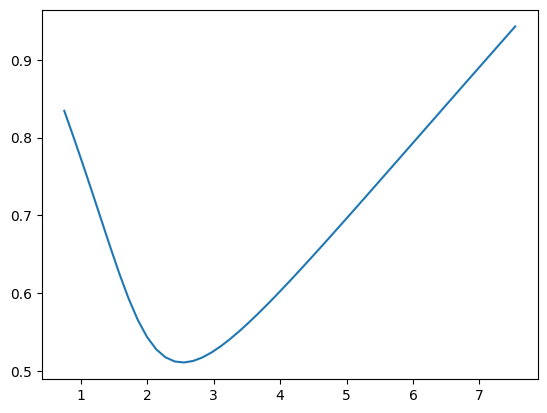

In [16]:
plt.plot(numpy.linspace(500,5000)/zfactor.pcrit,zvalues)